In this notebook I do first some data cleaning, then I perform some basic analysis of the dataset (no. cases per year, correlation population/no. of cases etc...).
<p>
I analyze finally the simplified municipalities indicators. In particular, I use Lasso Regression to find out the features that are most correlated to the no. of cases. I also analyze the features themself, to see how they are correlated to each other and how they are clustered together.

# Data preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)
%matplotlib inline

## Data loading

### Some checking first

The following are the dataset files containing KPI data. They have to be loaded and concatenated as a single pandas dataframe.

In [2]:
data_dir = './'

In [3]:
kpi_files = [data_dir + kpi for kpi in ['kpis_1998_2003.csv',
                                        'kpis_2004_2008.csv',
                                        'kpis_2009_2011.csv',
                                        'kpis_2012_2013.csv']]

I want to be sure that headers are consistent for all KPI files. I raise an exception if that is not the case.

In [4]:
# Check that all headers are the same
curHeaders = None
for csv in kpi_files:
    with open(csv, 'r') as f:
        for line in f:
            if curHeaders is None:
                curHeaders = line.strip()
            elif curHeaders != line.strip():
                    raise Exception('KPI headers mismatch')
            break

In [5]:
kpis = pd.concat([pd.read_csv(f) for f in kpi_files])
'Total number of KPIs: {}'.format(len(kpis.index))

/Users/guido/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


'Total number of KPIs: 5496166'

I load now the other CSV files as pandas dataframes.

In [6]:
municipality_indicators = pd.read_csv(data_dir + 'municipality_indicators.csv')
simplified_municipality_indicators = pd.read_csv(data_dir + 'simplified_municipality_indicators.csv')
school_fire_cases = pd.read_csv(data_dir + 'school_fire_cases_1998_2014.csv')

## Data cleaning

After some manual data wrangling, I've noticed that KPI files contain the same header line multiple times. I guess each file is a concationation of many original smaller files. I will remove this lines manually.

In [7]:
# Rows to be removed will have field 'kpi' equal to string 'kpi', 'period' equal to 'period'
# and so on. One single check on the first attribute should be enough.
kpis = kpis[kpis['kpi'] != 'kpi']
'Total number of KPIs after cleaning: {}'.format(len(kpis.index))

'Total number of KPIs after cleaning: 5496154'

The value field contains sometimes the string "None". For the purposes of this analysis it should be fine to set it to zero. Then I convert both period and value to numeric types. They will be used below during the analysis.

In [8]:
print(kpis.dtypes)
kpis['period'] = kpis['period'].astype(int)
kpis['value'] = kpis['value'].replace(['None'], [0.]).astype(float)
print(kpis.dtypes)

kpi                  object
period               object
municipality_id      object
municipality_name    object
value                object
kpi_desc             object
dtype: object
kpi                   object
period                 int64
municipality_id       object
municipality_name     object
value                float64
kpi_desc              object
dtype: object


Check that municipality names of KPIs data match those of simplified municipality indicators (SMIs).

In [9]:
names_simplified_municipality_indicators = set(simplified_municipality_indicators['name'])
names_kpis = set(kpis['municipality_name'])
assert names_simplified_municipality_indicators ^ names_kpis == set()


In [10]:
municipality_types = set(simplified_municipality_indicators['municipalityType'])
'Number of municipality types = {}'.format(len(municipality_types))

'Number of municipality types = 10'

# Data Analisys

## Misc stats

In [11]:
total_fire_cases = school_fire_cases['Cases'].sum()
cases_years = school_fire_cases['Year']
print('Number of unique years = {}'.format(len(cases_years.unique())))
period_desc = '{}-{}'.format(cases_years.min(), cases_years.max())
print('Number of total fire cases in period {} = {}'.format(period_desc, total_fire_cases))
print('Total number of municipalities = {}'.format(len(school_fire_cases['Municipality'].unique())))

Number of unique years = 17
Number of total fire cases in period 1998-2014 = 3088
Total number of municipalities = 290


## Municipalities with the highest number of cases

In [12]:
total_cases_by_municipality = school_fire_cases.groupby('Municipality').sum()['Cases'].sort_values(ascending=False)

In [13]:
max_cases_per_year = school_fire_cases.sort_values(by='Cases', ascending=False) \
    .groupby('Year', as_index=False) \
    .first()
print('The following municipalities were the ones the highest number of cases during the period {}:\n{}' \
      .format(period_desc, max_cases_per_year['Municipality'].unique()))

The following municipalities were the ones the highest number of cases during the period 1998-2014:
['Stockholm' 'Göteborg' 'Malmö']


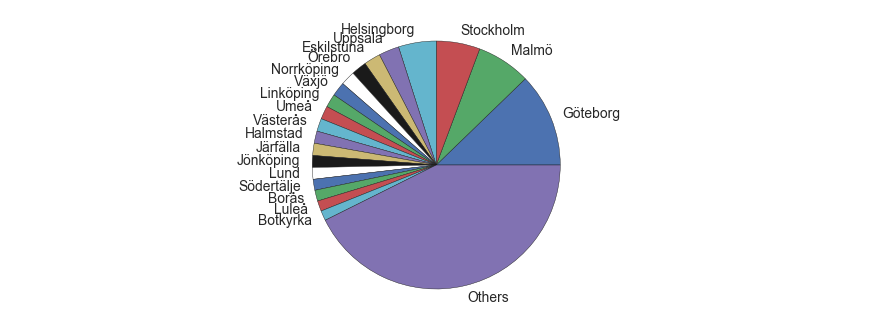

In [14]:
piechart_data = total_cases_by_municipality[:20]
others = total_cases_by_municipality[20:]
piechart_data.set_value('Others', others.sum())
f, ax = plt.subplots(figsize=(11, 4))
plt.axis('equal');
plt.pie(piechart_data, labels=piechart_data.index);

## Cases by year

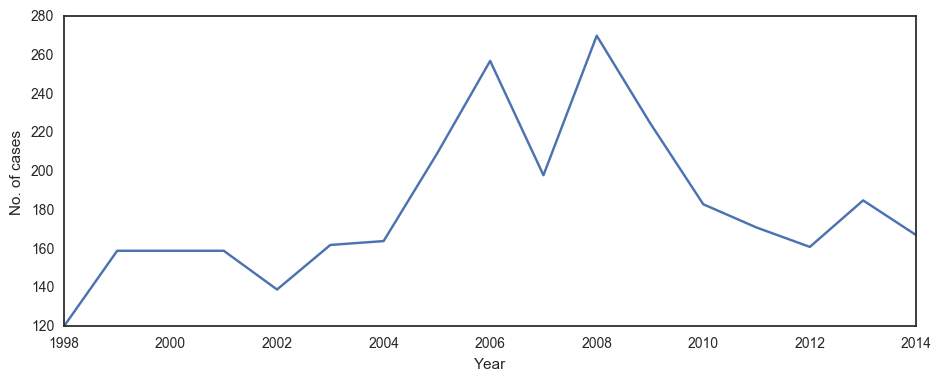

In [15]:
cases_by_year = school_fire_cases.groupby('Year')
f, ax = plt.subplots(figsize=(11, 4))
plt.xlabel('Year')
plt.ylabel('No. of cases')
_ = plt.plot(cases_by_year.sum()['Cases'])

## Histogram no. of cases by municipalities

In [16]:
print('Average cases = {}, standard deviation = {}, median = {}, 75th percentile = {}'.format(total_cases_by_municipality.mean(),
                                                                                              total_cases_by_municipality.std(),
                                                                                              total_cases_by_municipality.quantile(.5),
                                                                                              total_cases_by_municipality.quantile(.75)))
f, ax = plt.subplots(figsize=(11, 4))
plt.xlabel('No. of cases')
plt.ylabel('No. of municipalities')
_ = plt.hist(total_cases_by_municipality, bins=100)

Average cases = 10.648275862068965, standard deviation = 30.787705053871388, median = 3.0, 75th percentile = 9.0


## Correlation population / no. of cases

I show some misc info about population and no. of cases and then I compute and show their correlation.

In [17]:
population = school_fire_cases['Population']
print('Max population = {}, min population = {}'.format(population.max(), population.min()))
cases = school_fire_cases['Cases']
print('Max cases = {}, min cases = {}'.format(cases.max(), cases.min()))

Max population = 911989, min population = 2421
Max cases = 48, min cases = 0


In [18]:
reg = linear_model.LinearRegression()
features = np.array([[pp] for pp in population.values])
targets = np.array([[cc] for cc in cases.values])
reg.fit(features, targets)
print('Slope = {}, intercept = {}, score (R^2) = {}'.format(reg.coef_[0], reg.intercept_, reg.score(features, targets)))

Slope = [  2.42343327e-05], intercept = [-0.14164672], score (R^2) = 0.48512158381995985


In [19]:
f, ax = plt.subplots(figsize=(11, 4))
plt.xlim([0, 1000000])
plt.ylim([0,60])
plt.scatter(population, cases)
_ = plt.plot(features, reg.predict(features), color='r')

## Mean value of KPIs

I plot here the mean value of KPIs aggregated by year. I see some similarities with the "Cases by year" plot. Are KPI values and no. of cases correlated? I would have expected the opposite.

In [20]:
kpis_by_municipality = kpis['value'].groupby(kpis['municipality_name'])
kpis_by_period = kpis['value'].groupby(kpis['period'])

In [21]:
f, ax = plt.subplots(figsize=(11, 4))
plt.xlabel('Year')
plt.ylabel('Mean KPI value')
_ = plt.plot(kpis_by_period.mean())

# Features analysis

Let's choose a subset of SMIs features that make sense.

In [22]:
mun_indicators_features_list = ['medianIncome',
                                'youthUnemployment2010',
                                'youthUnemployment2013',
                                'unemploymentChange',
                                'reportedCrime',
                                'populationChange',
                                'hasEducation',
                                'asylumCosts',
                                'urbanDegree',
                                'foreignBorn',
                                'reportedCrimeVandalism',
                                'youngUnskilled',
                                'latitude',
                                'longitude',
                                'population',
                                'populationShare65plus',
                                'refugees',
                                'rentalApartments',
                                'fokusRanking',
                                'foretagsklimatRanking',
                                'cars',
                                'motorcycles',
                                'tractors',
                                'snowmobiles']

In [23]:
mun_indicators_features = simplified_municipality_indicators.loc[:, mun_indicators_features_list].as_matrix()
y_cases = [total_cases_by_municipality[m] for m in simplified_municipality_indicators['name']]

## Lasso regression

Using Lasso regression on selected features of the simplified KPIs dataframe to compute the importance of each single feature.

In [24]:
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(mun_indicators_features, y_cases)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [25]:
lasso.coef_

array([ -3.24702632e-04,  -1.04247182e-01,  -1.96953332e-01,
         0.00000000e+00,  -8.58331768e-03,  -5.93074264e-01,
         2.49111278e-01,  -1.12200920e-04,  -1.24879755e-02,
         3.15869810e-01,   7.34269539e-01,  -2.07054768e-01,
        -1.51424925e-02,  -1.04951291e+00,   3.16347626e-04,
        -1.24521623e+00,   3.11736523e-02,   2.76162738e-02,
        -7.76100741e-03,   1.47420267e-02,   2.37996265e-02,
        -1.43994788e-01,  -4.25679066e-02,   3.20220502e-03])

In [26]:
features_by_coef = sorted(zip(mun_indicators_features_list, lasso.coef_), key=lambda tup: tup[1], reverse=True)
chart_x = [t[0] for t in features_by_coef]
chart_y = [t[1] for t in features_by_coef]

### Bar chart of importance by feature

The most positively correlated features are "reportedCrimeVandalism", "foreignBorn" and "hasEducation", the most negatively correlated are "populationShare65plus", "longitude" (but why?), "populationChange", "youngUnskilled" (they didn't go to school?). But "youthUnemployment" and "motorcycles"?

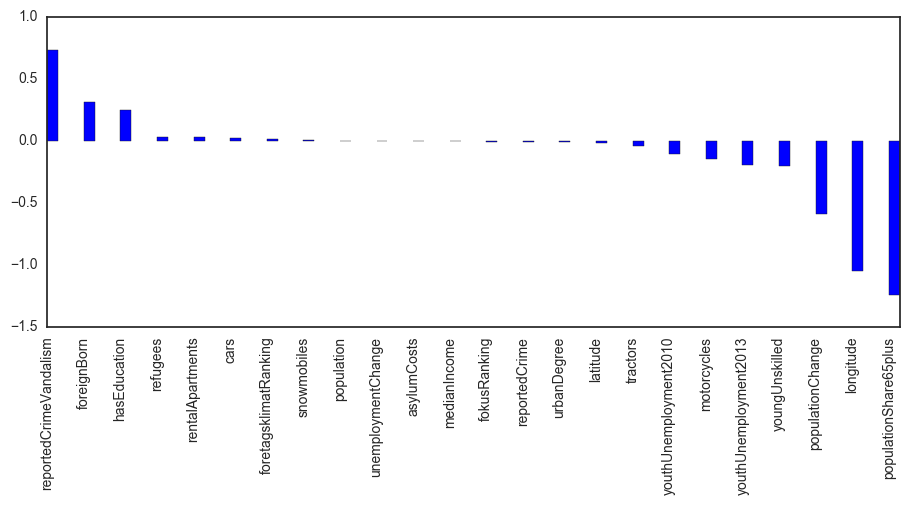

In [27]:
f, ax = plt.subplots(figsize=(11, 4))
plt.xticks(range(len(chart_x)), chart_x)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
_ = ax.bar(range(len(chart_x)), chart_y, 0.3, color="blue")

## Correlation of SMIs

I plot the correlation between the SMIs features as a heatmap.

In [28]:
indicators_and_cases = simplified_municipality_indicators.loc[:, mun_indicators_features_list]
cor_mat = simplified_municipality_indicators.loc[:, mun_indicators_features_list].corr()

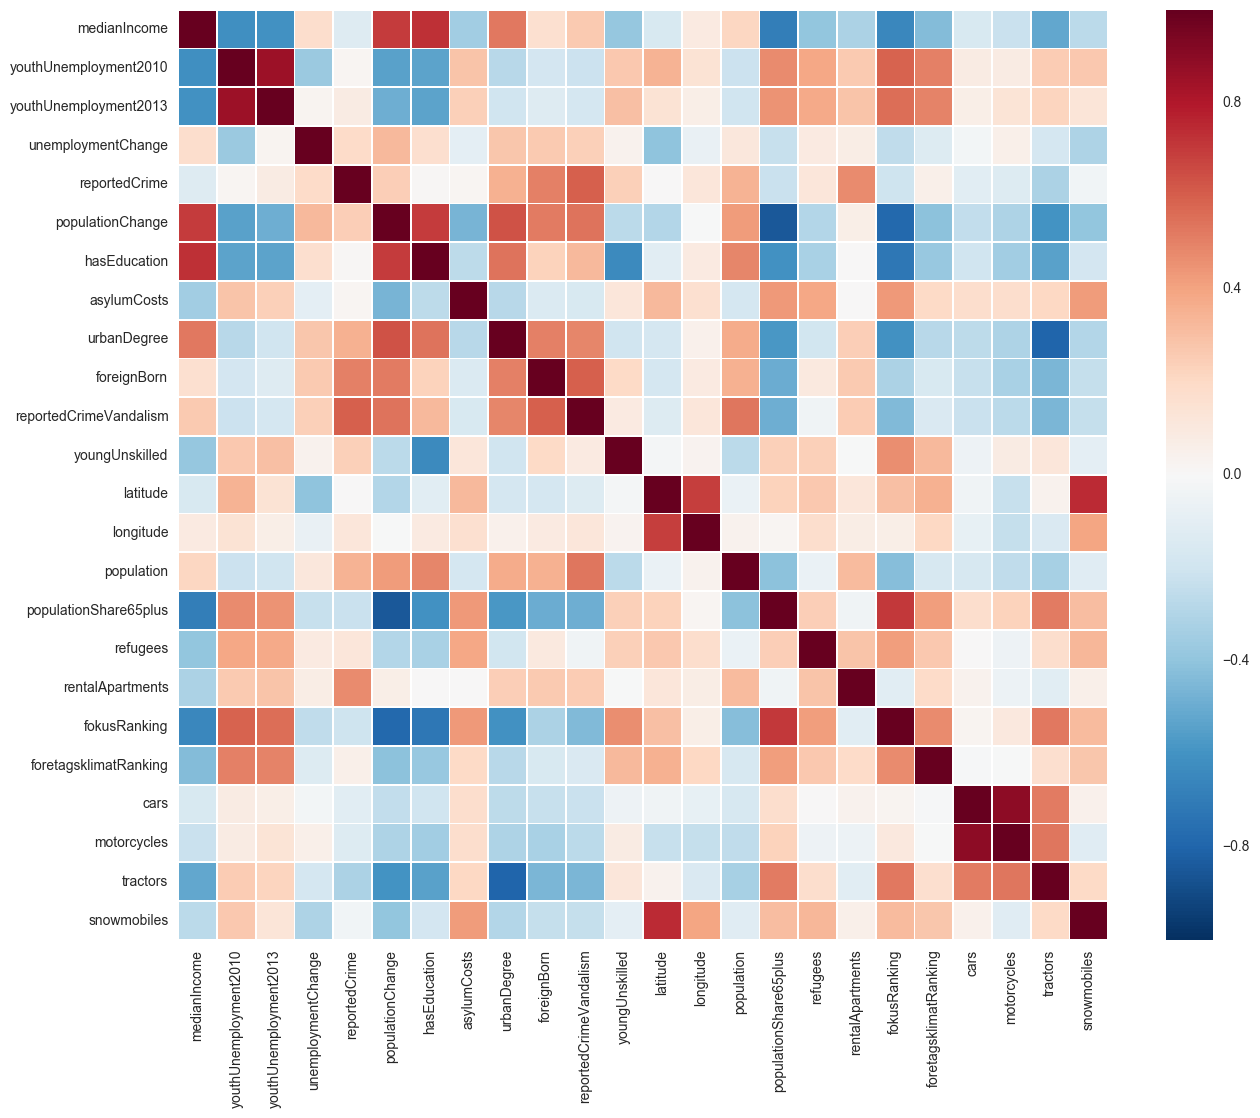

In [29]:
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(cor_mat,linewidths=.5, ax=ax);

I show in the following table the most important correlations, filtering out auto-correlations. Obvious: latitude/snowmobiles, tractors/urbanDegree, youthUnemployment2010/youthUnemployment2013. Interesting: hasEducation/mediaIncome, populationChange, populationShare65plus (negative).

In [30]:
threshold = 0.7
important_corrs = (cor_mat[abs(cor_mat) > threshold][cor_mat != 1.0]) \
    .unstack().dropna().to_dict()
unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), columns=['attribute pair', 'correlation'])
# sorted by absolute value
unique_important_corrs = unique_important_corrs.ix[
    abs(unique_important_corrs['correlation']).argsort()[::-1]]
unique_important_corrs

attribute pair  correlation
0                             (cars, motorcycles)     0.896457
3  (youthUnemployment2010, youthUnemployment2013)     0.851773
7       (populationChange, populationShare65plus)    -0.846804
2                         (tractors, urbanDegree)    -0.801430
9                (fokusRanking, populationChange)    -0.785580
8                         (latitude, snowmobiles)     0.746826
4                    (hasEducation, medianIncome)     0.730192
5                    (fokusRanking, hasEducation)    -0.722544
6           (fokusRanking, populationShare65plus)     0.710866
1                (medianIncome, populationChange)     0.702702

## Features clusters as clustermap

In [31]:
# See https://www.kaggle.com/cast42/santander-customer-satisfaction/exploring-features
import matplotlib.patches as patches
from scipy.cluster import hierarchy
from scipy.stats.mstats import mquantiles
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

In [32]:
# scale to mean 0, variance 1
train_std = pd.DataFrame(scale(indicators_and_cases))
train_std.columns = indicators_and_cases.columns
m = train_std.corr()
l = linkage(m, 'ward')

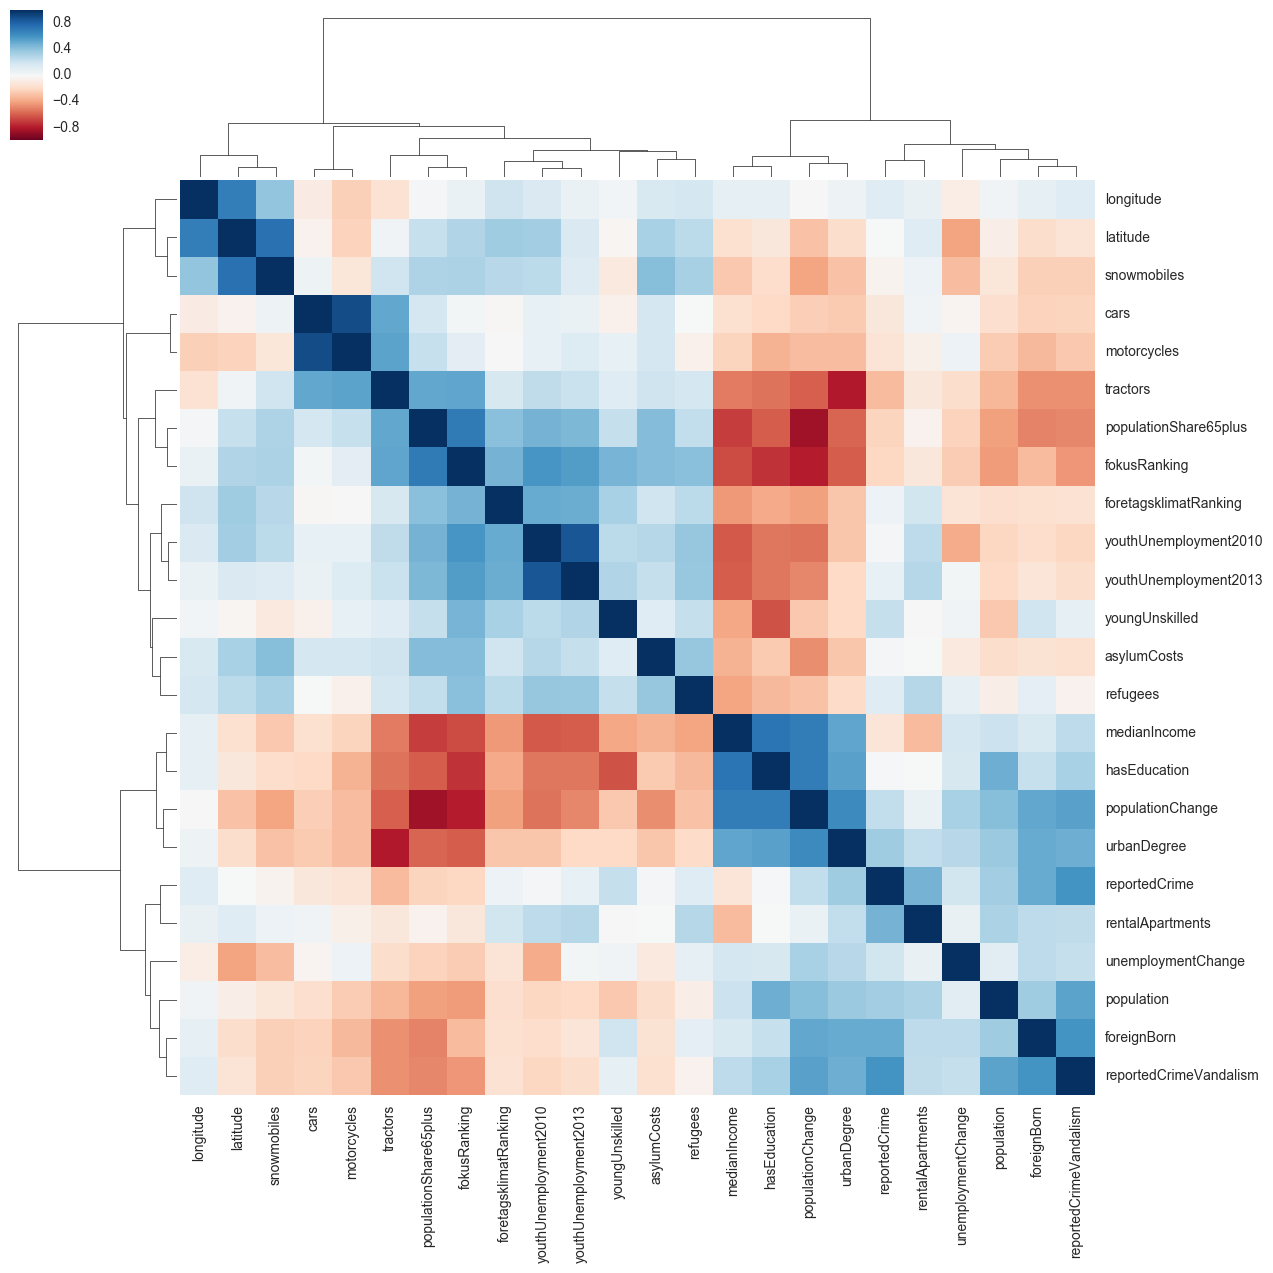

In [33]:
mclust = sns.clustermap(m,
               linewidths=0,
               cmap=plt.get_cmap('RdBu'),
               vmax=1,
               vmin=-1,
               figsize=(14, 14),
               row_linkage=l,
               col_linkage=l)
# http://stackoverflow.com/a/34697479/297313
_ = plt.setp(mclust.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)